In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
from pycocotools.coco import COCO
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

%matplotlib inline
torch.cuda.empty_cache()
# class CustomDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
        
#         self.classes = os.listdir(self.root_dir)
#         self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
#         self.paths = []
#         self.labels = []

#         for class_name in self.classes:
#             class_dir = os.path.join(self.root_dir, class_name)
#             for filename in os.listdir(class_dir):
#                 self.paths.append(os.path.join(class_dir, filename))
#                 self.labels.append(self.class_to_idx[class_name])

#     def __len__(self):
#         return len(self.paths)

#     def __getitem__(self, idx):
#         image_path = self.paths[idx]
#         label = self.labels[idx]

#         image = Image.open(image_path)
#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [2]:
print(torch.__version__)

2.1.0+cu118


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [4]:
file_path = 'train_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,weld_0001-810-small-0-r.jpg,23653,{},1,0,"{""name"":""rect"",""x"":34,""y"":190,""width"":54,""heig...",{}
1,weld_0001-810-small-1-r.jpg,24230,{},1,0,"{""name"":""rect"",""x"":15,""y"":194,""width"":55,""heig...",{}
2,weld_0001-810-small-1-r-adj.jpg,38088,{},1,0,"{""name"":""rect"",""x"":2,""y"":207,""width"":50,""heigh...",{}
3,weld_0001-820-small-0-l-adj.jpg,41993,{},1,0,"{""name"":""rect"",""x"":153,""y"":159,""width"":53,""hei...",{}
4,weld_0001-820-small-0-r.jpg,23413,{},1,0,"{""name"":""rect"",""x"":34,""y"":152,""width"":56,""heig...",{}


In [5]:
import json

def extract_bounding_box(region_shape_attributes):
    # Load the JSON data
    region_dict = json.loads(region_shape_attributes)

    # Extract coordinates
    xmin = region_dict.get('x', 0)
    ymin = region_dict.get('y', 0)
    width = region_dict.get('width', 0)
    height = region_dict.get('height', 0)

    # Calculate xmax and ymax
    xmax = xmin + width
    ymax = ymin + height

    return ymin, xmin, ymax, xmax

In [6]:
img_size = 64

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(csv_file)

        # Extract unique class names and assign integer labels
        self.classes = self.data['region_attributes'].unique()  # Modify as per the actual column for class labels if different
        self.class_to_int = {c: idx for idx, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx]['filename'])
        image = Image.open(img_name).convert("RGB")
        orig_width, orig_height = image.size
        
        if self.transform:
            image = self.transform(image)

       
        scale_x = img_size / orig_width
        scale_y = img_size / orig_height

        # Extract bounding box coordinates from JSON in 'region_shape_attributes'
        region_shape_attributes = self.data.iloc[idx]['region_shape_attributes']
        region_dict = json.loads(region_shape_attributes)
        xmin = region_dict.get('x', 0) * scale_x
        ymin = region_dict.get('y', 0) * scale_y
        width = region_dict.get('width', 0) * scale_x
        height = region_dict.get('height', 0) * scale_y
        xmax = xmin + width
        ymax = ymin + height
        box = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)

        iscrowd = torch.zeros((box.shape[0],), dtype=torch.int64)

        # # Extract label and convert to tensor (modify as per actual data)
        # label_name = self.data.iloc[idx]['region_attributes']  # Modify as per the actual column for class labels if different
        # label = self.class_to_int.get(label_name, 1)
        label_tensor = torch.tensor([0], dtype=torch.int64)
        area = torch.tensor([(xmax - xmin) * (ymax - ymin)], dtype=torch.float64)

        target = {}
        target["boxes"] = box
        target["labels"] = label_tensor
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])


        return image, target
    
# Example usage:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize should be applied on a PIL Image
    transforms.ToTensor(),  # Convert the PIL Image to a tensor

])




def collate_fn(batch):
    return tuple(zip(*batch))


dataset = CustomImageDataset(csv_file='C:/Users/denis/Desktop/VIR/Projekt/train_data.csv', root_dir='C:/Users/denis/Desktop/VIR/Projekt/train/510/', transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn)

test_dataset = CustomImageDataset(csv_file='C:/Users/denis/Desktop/VIR/Projekt/test_data.csv', root_dir='C:/Users/denis/Desktop/VIR/Projekt/test/510/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,  collate_fn=collate_fn)

print('length of train dataset = ', len(dataset), '\n')

length of train dataset =  160 



[10.285714   0.6857143 28.114286  62.4      ]


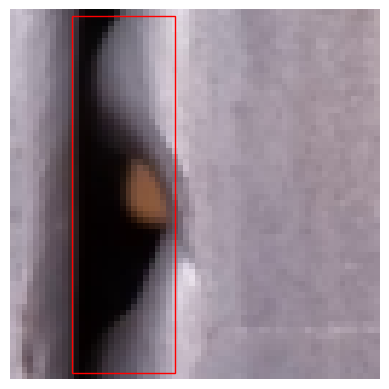

In [7]:
def show_tensor_image_with_box(tensor_image, box):
    # Convert from tensor to numpy
    numpy_image = tensor_image.permute(1, 2, 0).numpy()

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(numpy_image)

    # Create a Rectangle patch
    # Unpack the box coordinates
    x_min, y_min, x_max, y_max = box
    
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.axis('off')  # Turn off axis numbers
    plt.show()

for images, targets in test_loader:

    if len(images) > 0:
        first_image = images[0]
        first_target = targets[0]

        box = first_target['boxes'][0].cpu().numpy() 
        print(box)
        show_tensor_image_with_box(first_image, box)
        break 

In [8]:
model = torch.load('model_epoch_15-64x.pth')

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'model_epoch_15-64x.pth'

In [ ]:
# model.eval()  # Set model to evaluation mode
# all_predictions = []
# all_targets = []
# test_images, test_preds = [], []

# with torch.no_grad():
#     for images, targets in test_loader:
#         images = list(img.to(device) for img in images)
#         predictions = model(images)
#         all_predictions.extend(predictions)
#         all_targets.extend(targets)
#         test_images.extend(images)
#         test_preds.extend(predictions)
#         outputs = model(images)
#         print(predictions)

In [ ]:
model.eval()  # Set model to evaluation mode
all_predictions = []
all_targets = []
test_images, test_preds = [], []
confidence_threshold = 0.2

with torch.no_grad():
    for images, targets in test_loader:
        images = list(img.to(device) for img in images)
        predictions = model(images)
        print(predictions)

        all_predictions.extend(predictions)
        all_targets.extend(targets)
        test_images.extend(images)
        test_preds.extend(predictions)

[{'boxes': tensor([[63.9939,  0.0000, 64.0000,  2.5507],
        [63.9914, 56.4418, 64.0000, 61.0849],
        [63.9941, 54.5967, 64.0000, 58.9377],
        [63.9967, 54.9395, 64.0000, 59.4065]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1907, 0.1907, 0.1907, 0.1907], device='cuda:0')}, {'boxes': tensor([[63.9892, 18.5468, 64.0000, 23.9119],
        [63.9895, 32.1282, 64.0000, 37.2731],
        [63.9977, 48.0326, 64.0000, 53.7795],
        [63.9933, 44.7481, 64.0000, 50.6736],
        [63.9964, 46.5867, 64.0000, 52.2337],
        [63.9982, 19.5059, 64.0000, 24.9484],
        [63.9948, 48.5881, 64.0000, 54.9805],
        [63.9984, 34.0600, 64.0000, 39.5820],
        [63.9913,  0.8541, 64.0000,  5.2053],
        [63.9931, 52.8653, 64.0000, 58.8069],
        [63.9975, 54.9953, 64.0000, 60.4374]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1907, 0.1907, 0.1907, 0.1907, 0.1907, 0.19

63.993885 0.0 64.0 2.5507393
63.991352 56.44179 64.0 61.084934
63.994053 54.59675 64.0 58.937664
63.99675 54.939476 64.0 59.406467
No boxes to display.


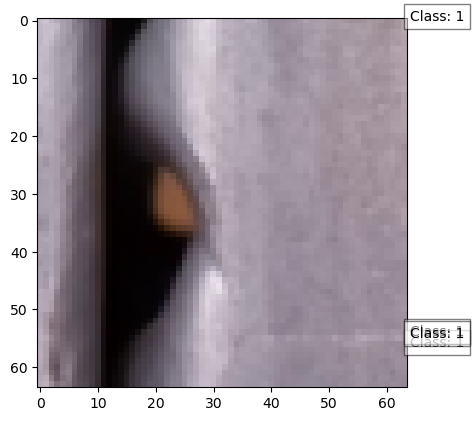

63.98918 18.546778 64.0 23.911938
63.989487 32.128174 64.0 37.273083
63.997734 48.032578 64.0 53.77953
63.993343 44.748085 64.0 50.673553
63.996445 46.586697 64.0 52.23372
63.998215 19.50593 64.0 24.948425
63.994755 48.588142 64.0 54.980457
63.998394 34.059963 64.0 39.582005
63.991302 0.85413635 64.0 5.2052746
63.993134 52.86535 64.0 58.806904
63.99754 54.995327 64.0 60.437424
No boxes to display.


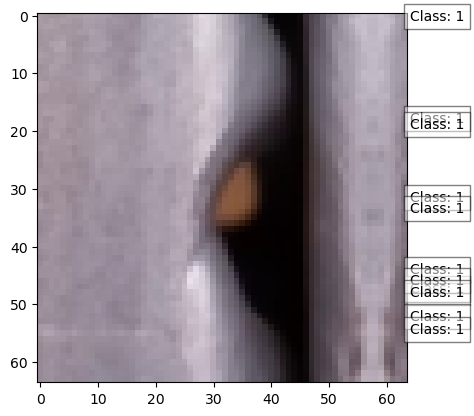

63.99313 0.0 64.0 2.5197198
No boxes to display.


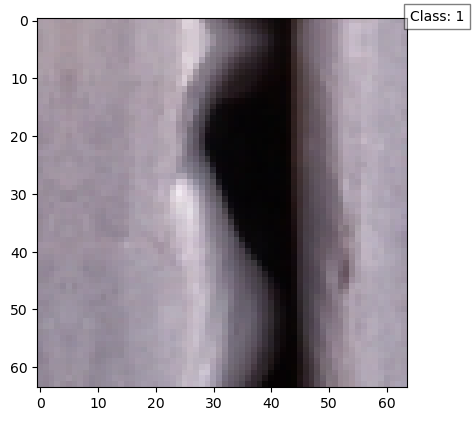

No boxes to display.


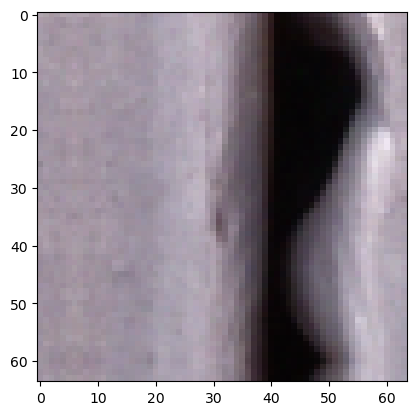

63.991005 0.8503915 64.0 4.463457
63.992474 56.642162 64.0 61.220337
No boxes to display.


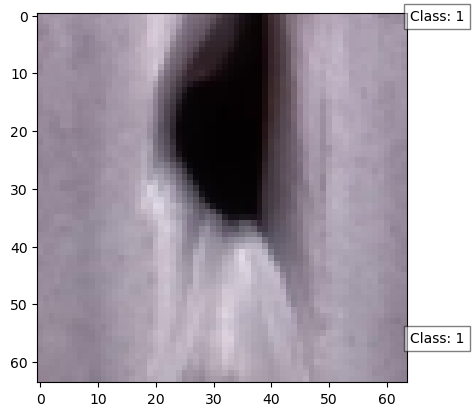

63.99285 55.492973 64.0 61.39436
No boxes to display.


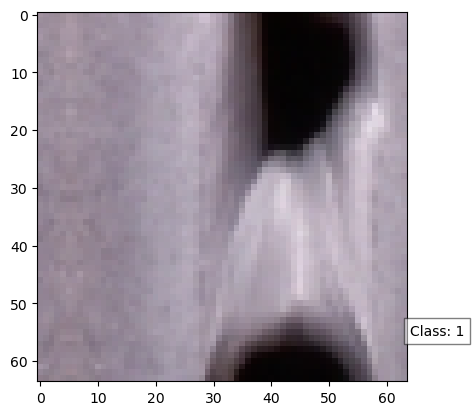

No boxes to display.


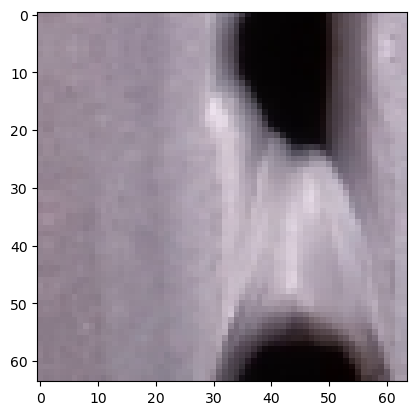

63.991955 54.555622 64.0 60.461346
No boxes to display.


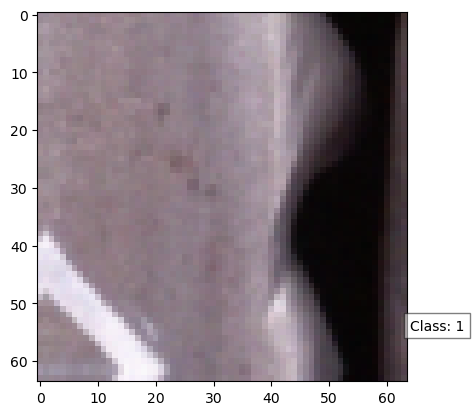

63.990948 0.9695323 64.0 4.8588977
63.997074 1.2784399 64.0 5.131106
63.995834 55.905872 64.0 61.022133
No boxes to display.


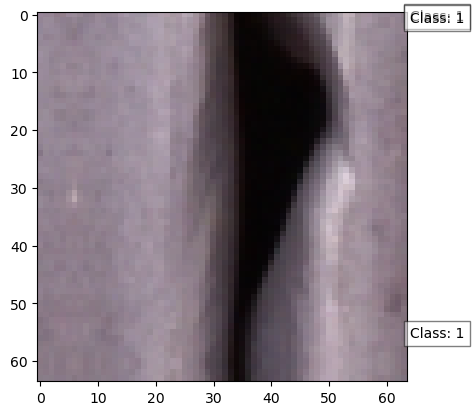

63.99872 20.508282 64.0 24.468979
63.98865 24.028568 64.0 28.108177
63.991177 45.974476 64.0 50.614048
63.9945 24.36385 64.0 28.482561
63.98885 28.664055 64.0 32.276634
63.997562 21.80347 64.0 25.961927
63.999077 47.907093 64.0 52.391956
63.994896 36.67238 64.0 41.11765
63.988842 36.22396 64.0 40.985126
No boxes to display.


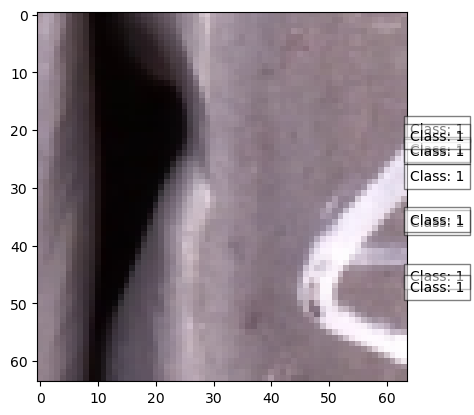

63.993748 58.658962 64.0 62.925213
63.99819 56.861862 64.0 61.746727
63.999035 59.08357 64.0 63.16676
No boxes to display.


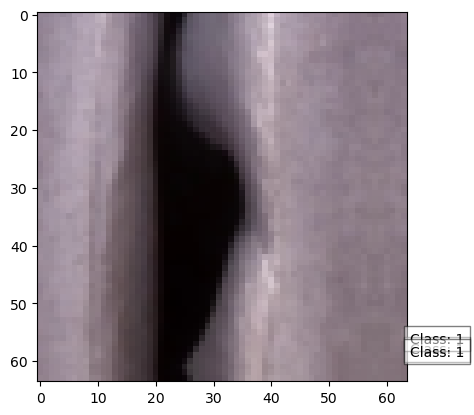

63.993046 0.5034245 64.0 4.130545
63.997993 58.188118 64.0 62.604504
No boxes to display.


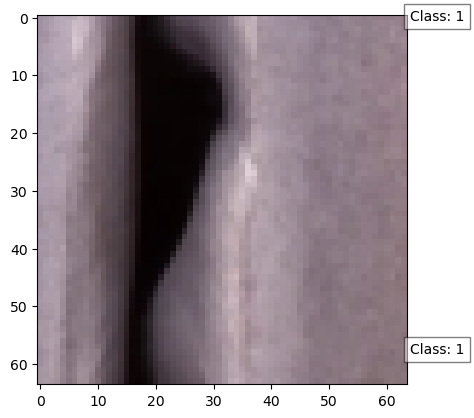

No boxes to display.


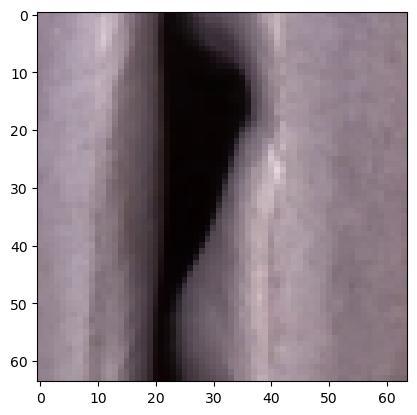

63.99287 1.0212392 64.0 4.934865
63.997894 1.2764729 64.0 5.241373
63.994873 56.24622 64.0 61.095154
No boxes to display.


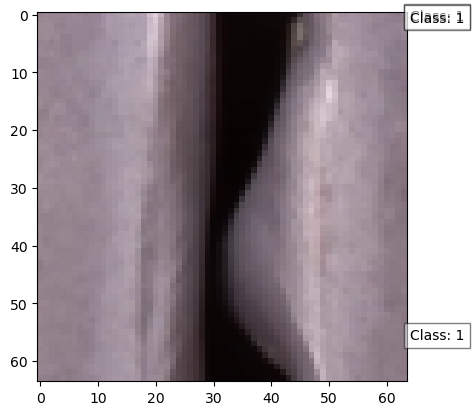

63.997044 56.317196 64.0 61.237488
63.994335 1.2648784 64.0 5.5126834
No boxes to display.


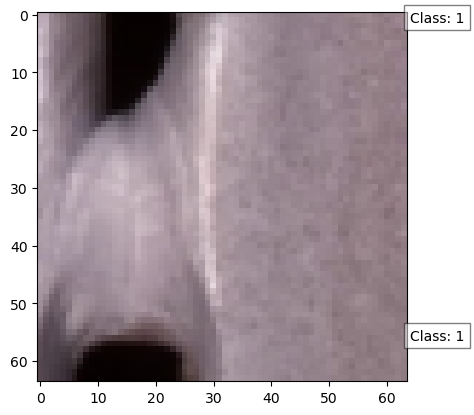

63.995438 1.2445779 64.0 5.165497
No boxes to display.


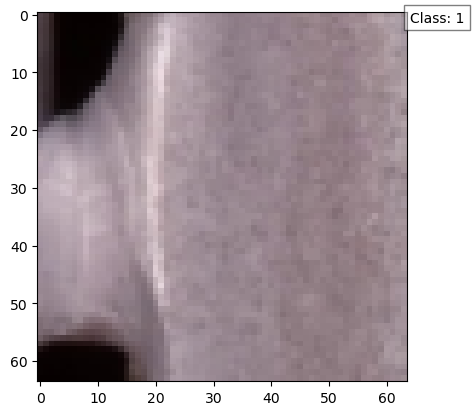

63.99675 55.86979 64.0 60.823685
63.990574 56.479385 64.0 61.205524
63.997772 57.158417 64.0 61.729317
63.997444 0.0 64.0 2.7044013
No boxes to display.


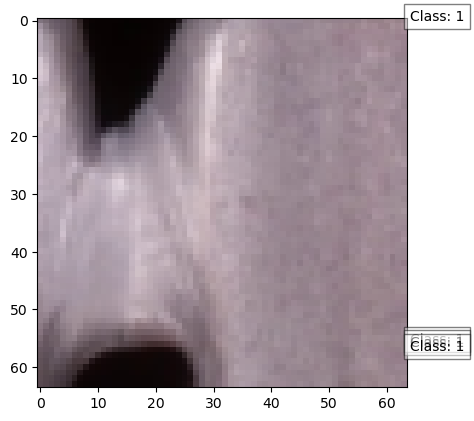

63.99648 0.98796904 64.0 4.4543824
No boxes to display.


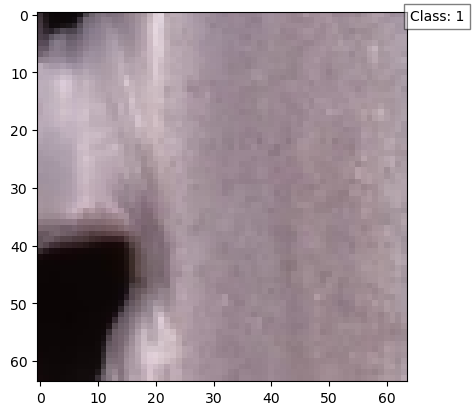

63.99425 55.53826 64.0 60.708565
No boxes to display.


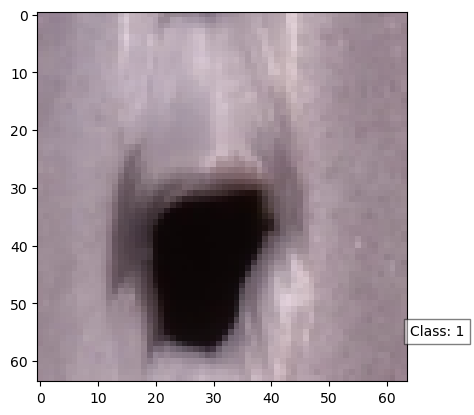

63.989006 0.0 64.0 2.9907317
No boxes to display.


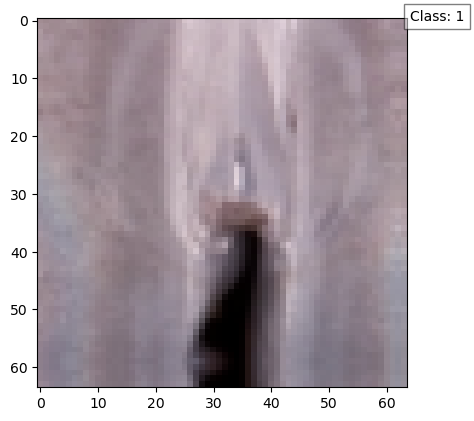

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(image, boxes, labels):
    # Convert tensor image to numpy and transpose from CxHxW to HxWxC
    np_image = image.cpu().numpy().transpose(1, 2, 0)
    np_image = np.clip(np_image, 0, 1)  # Clamp values to the valid range

    fig, ax = plt.subplots(1)
    ax.imshow(np_image)

    # Check if boxes is not empty
        
    for box, label in zip(boxes, labels):
        # Unpack the box coordinates
        x_min, y_min, x_max, y_max = box

        print(x_min, y_min, x_max, y_max)
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                linewidth=5, edgecolor='r', facecolor='none')

        ax.add_patch(rect)
     
        plt.text(x_min, y_min, f'Class: {label}', bbox=dict(facecolor='white', alpha=0.5))
    else:
        print("No boxes to display.")

    plt.show()

# Display images with predictions
for image, prediction in zip(test_images[:20], test_preds[:20]):  # Display first 10 images
    boxes = prediction['boxes'].cpu().numpy() 
    labels = prediction['labels'].cpu().numpy() 
   
    show_image_with_boxes(image, boxes, labels)

In [ ]:
def calculate_iou(pred_box, gt_box):
    # Coordinates of the intersection box
    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])

    # Area of intersection
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Area of both the prediction and ground truth boxes
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    # Union area
    union_area = pred_area + gt_area - inter_area

    # IoU calculation
    iou = inter_area / union_area

    return iou


In [ ]:
num_classes = 4  # Including background
iou_threshold = 0.5

# Initialize containers for TP and FP across classes
tps = {cls: [] for cls in range(num_classes)}
fps = {cls: [] for cls in range(num_classes)}

for prediction, target in zip(all_predictions, all_targets):
    # For each class, calculate IoU, TP, FP
    for cls in range(num_classes):
        pred_boxes = prediction['boxes'][prediction['labels'] == cls].cpu().numpy()
        gt_boxes = target['boxes'][target['labels'] == cls].cpu().numpy()
        num_gts = len(gt_boxes)

        confidences = prediction['scores'][prediction['labels'] == cls].cpu().numpy()
        sorted_indices = np.argsort(-confidences)
        pred_boxes = pred_boxes[sorted_indices]

        matched = np.zeros(num_gts, dtype=np.bool_)

        for pred_box in pred_boxes:
            if num_gts == 0:
                fps[cls].append(1)
                continue

            ious = [calculate_iou(pred_box, gt) for gt in gt_boxes]
            best_iou_idx = np.argmax(ious)
            best_iou = ious[best_iou_idx]

            if best_iou >= iou_threshold and not matched[best_iou_idx]:
                tps[cls].append(1)
                fps[cls].append(0)
                matched[best_iou_idx] = True
            else:
                fps[cls].append(1)
                tps[cls].append(0)
